# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [5]:
# Import required libraries
# Add whatever you want
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

TensorFlow Version 1.3.0


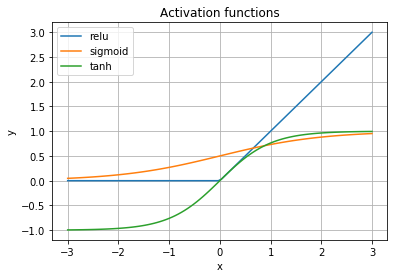

In [6]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [7]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [9]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']
    
    
def load_train_data():

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
	data_path = "data/cifar-10-batches-py"
	all_batches = []
	all_labels = []
    
	for b in range(1,6):
		f_train_curr = os.path.join(data_path, 'data_batch_%d' % (b, ))
		d = unpickle(f_train_curr)
		batch = d[0].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
		labels = np.array(d[1])
		all_batches.append(batch)
		all_labels.append(labels)
	data_train = np.concatenate(all_batches)
	labels_train = np.concatenate(all_labels)
	data_val = data_train[range(num_training, num_training+num_validation)]
	labels_val = labels_train[range(num_training, num_training+num_validation)]
	data_train = data_train[range(num_training)]
	labels_train = labels_train[range(num_training)]
	return data_train, labels_train, data_val, labels_val

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
	data_path = "data/cifar-10-batches-py"
	f_test = os.path.join(data_path, 'test_batch')
	d = unpickle(f_test)
	data_test = d[0].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
	labels_test = np.array(d[1])
	return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [10]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def fully_connected(inputs, units, activation=None, kernel_regularizer=None, bias_regularizer=None):
     return tf.layers.dense(inputs=inputs, units=units, activation=activation)

def lrelu(x, alpha):
      return tf.nn.relu(x) - alpha * tf.nn.relu(-x)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [11]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2) 
            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.contrib.layers.flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_connected(self.flat, 384, None)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_connected(self.relu3, 10, None)    
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool, name='is_train')
        self.keep_prob = None
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        learning_decay_rate = tf.train.exponential_decay(learning_rate=5e-4,
                                                       global_step=global_step,
                                                       decay_steps=500,
                                                       decay_rate=0.96,
                                                       staircase=True
                                                      )
        self.train_op = tf.train.AdamOptimizer(learning_decay_rate).minimize(self.loss_op, global_step=global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                              labels=labels, logits=logits))      
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_, self.is_train:True}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            plt.xlabel('Iteration')
            plt.plot(range(len(losses)), losses, label='loss')
            
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Training accuracy')
            plt.xlabel('Epoch')
            plt.plot(range(len(accuracies)), accuracies, label='accuracy')

            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_, self.is_train:False}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 17.861, accuracy = 0.078
iteration (50): loss = 1.901, accuracy = 0.289
iteration (100): loss = 1.571, accuracy = 0.422
iteration (150): loss = 1.789, accuracy = 0.375
iteration (200): loss = 1.626, accuracy = 0.445
iteration (250): loss = 1.624, accuracy = 0.422
iteration (300): loss = 1.482, accuracy = 0.492
iteration (350): loss = 1.415, accuracy = 0.508


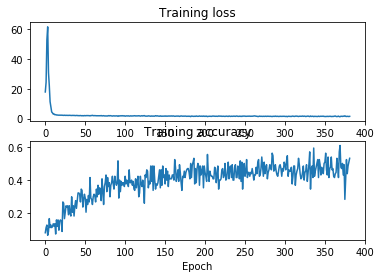

validation for epoch 0
-  epoch 0: validation accuracy = 0.512
train for epoch 1
iteration (400): loss = 1.373, accuracy = 0.484
iteration (450): loss = 1.338, accuracy = 0.500
iteration (500): loss = 1.422, accuracy = 0.453
iteration (550): loss = 1.221, accuracy = 0.594
iteration (600): loss = 1.324, accuracy = 0.594
iteration (650): loss = 1.339, accuracy = 0.547
iteration (700): loss = 1.199, accuracy = 0.555
iteration (750): loss = 1.088, accuracy = 0.617


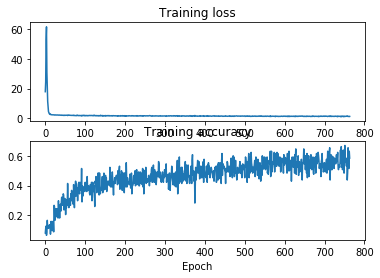

validation for epoch 1
-  epoch 1: validation accuracy = 0.548
train for epoch 2
iteration (800): loss = 1.169, accuracy = 0.570
iteration (850): loss = 1.291, accuracy = 0.547
iteration (900): loss = 1.022, accuracy = 0.641
iteration (950): loss = 1.071, accuracy = 0.641
iteration (1000): loss = 1.068, accuracy = 0.656
iteration (1050): loss = 1.158, accuracy = 0.578
iteration (1100): loss = 0.961, accuracy = 0.641


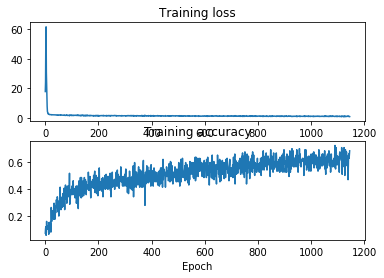

validation for epoch 2
-  epoch 2: validation accuracy = 0.585
train for epoch 3
iteration (1150): loss = 1.041, accuracy = 0.656
iteration (1200): loss = 0.841, accuracy = 0.680
iteration (1250): loss = 1.009, accuracy = 0.664
iteration (1300): loss = 1.206, accuracy = 0.617
iteration (1350): loss = 0.885, accuracy = 0.688
iteration (1400): loss = 1.023, accuracy = 0.688
iteration (1450): loss = 1.044, accuracy = 0.609
iteration (1500): loss = 0.881, accuracy = 0.664


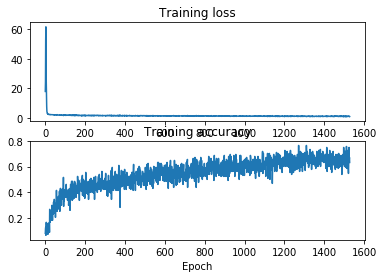

validation for epoch 3
-  epoch 3: validation accuracy = 0.566
train for epoch 4
iteration (1550): loss = 0.816, accuracy = 0.742
iteration (1600): loss = 0.881, accuracy = 0.773
iteration (1650): loss = 0.973, accuracy = 0.609
iteration (1700): loss = 0.918, accuracy = 0.664
iteration (1750): loss = 0.848, accuracy = 0.680
iteration (1800): loss = 0.905, accuracy = 0.680
iteration (1850): loss = 0.959, accuracy = 0.703
iteration (1900): loss = 0.886, accuracy = 0.711


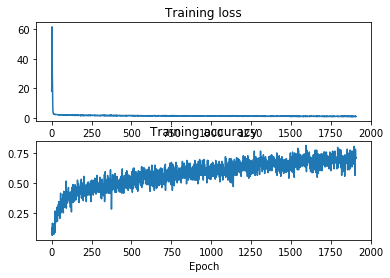

validation for epoch 4
-  epoch 4: validation accuracy = 0.614
***** test accuracy: 0.609
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [60]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [14]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 50
        

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = lrelu(self.conv1, 0.01)
            self.norm1 = tf.nn.lrn(self.relu1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                name='norm1')
            self.pool1 = max_pool(self.norm1, 3, 2)     
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = lrelu(self.conv2, 0.01)
            self.norm2 = tf.nn.lrn(self.relu2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                name='norm2')
            self.pool2 = max_pool(self.relu2, 3, 2)       
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.pool2, 3, 1, 32)
            self.relu3 = lrelu(self.conv3, 0.01)
            self.norm3 = tf.nn.lrn(self.relu3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                name='norm3')
            self.pool3 = max_pool(self.norm3, 3, 2)       
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv3 layer: ' + str(self.pool3.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.contrib.layers.flatten(self.pool3)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_connected(self.flat,384,None)
            dropout_3 = tf.layers.dropout(inputs=self.fc3, rate=self.keep_prob, 
                                        training = self.is_train) 
            self.relu3 = tf.nn.relu(dropout_3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_connected(self.relu3, 192, None)  
            dropout_4 = tf.layers.dropout(inputs=self.fc4, rate=self.keep_prob, 
                                        training = self.is_train) 
            self.relu4 = tf.nn.relu(dropout_4)
            #################################4###########################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))

        with tf.variable_scope('fc5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc5 = fully_connected(self.relu4, 10)          
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc5.get_shape()))

        # Return the last layer
        return self.fc5

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool, name='is_train')
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(5e-4, global_step, 1500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=global_step)        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                              labels=labels, logits=logits)
                      )    
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_, self.is_train : True, self.keep_prob: 0.4}           
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]
                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.plot(range(len(losses)), losses, label='loss')
            # Graph 2. X: epoch, Y: training accuracy
            plt.plot(range(len(accuracies)), accuracies, label='accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Loss/ Accuracy')
            plt.title("Loss vs Accuracy")
            plt.show()
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_, self.is_train : False, self.keep_prob: 1.0}         
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

    
    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 32)
flat layer: (?, 512)
fc3 layer: (?, 384)
fc4 layer: (?, 192)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 7.550, accuracy = 0.141
iteration (50): loss = 2.160, accuracy = 0.219
iteration (100): loss = 1.955, accuracy = 0.289
iteration (150): loss = 1.940, accuracy = 0.211
iteration (200): loss = 1.968, accuracy = 0.312
iteration (250): loss = 1.727, accuracy = 0.352
iteration (300): loss = 1.577, accuracy = 0.391
iteration (350): loss = 1.721, accuracy = 0.336


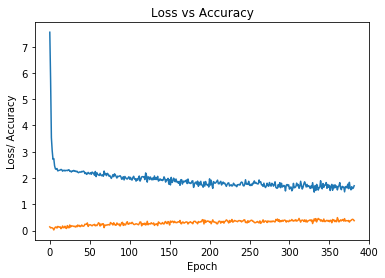

validation for epoch 0
-  epoch 0: validation accuracy = 0.443
train for epoch 1
iteration (400): loss = 1.648, accuracy = 0.445
iteration (450): loss = 1.620, accuracy = 0.406
iteration (500): loss = 1.703, accuracy = 0.375
iteration (550): loss = 1.456, accuracy = 0.523
iteration (600): loss = 1.565, accuracy = 0.492
iteration (650): loss = 1.620, accuracy = 0.375
iteration (700): loss = 1.520, accuracy = 0.453
iteration (750): loss = 1.337, accuracy = 0.547


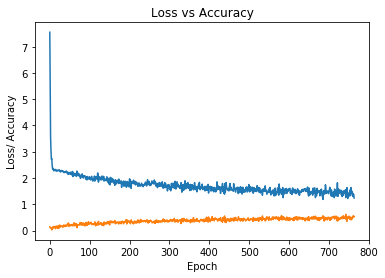

validation for epoch 1
-  epoch 1: validation accuracy = 0.541
train for epoch 2
iteration (800): loss = 1.393, accuracy = 0.477
iteration (850): loss = 1.427, accuracy = 0.500
iteration (900): loss = 1.292, accuracy = 0.539
iteration (950): loss = 1.264, accuracy = 0.578
iteration (1000): loss = 1.336, accuracy = 0.492
iteration (1050): loss = 1.318, accuracy = 0.555
iteration (1100): loss = 1.134, accuracy = 0.609


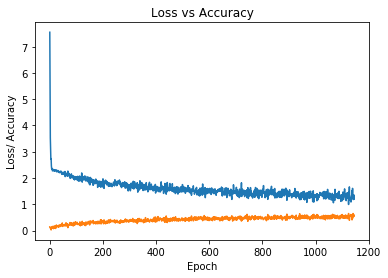

validation for epoch 2
-  epoch 2: validation accuracy = 0.575
train for epoch 3
iteration (1150): loss = 1.187, accuracy = 0.602
iteration (1200): loss = 1.136, accuracy = 0.602
iteration (1250): loss = 1.256, accuracy = 0.547
iteration (1300): loss = 1.348, accuracy = 0.570
iteration (1350): loss = 1.204, accuracy = 0.547
iteration (1400): loss = 1.372, accuracy = 0.562
iteration (1450): loss = 1.343, accuracy = 0.531
iteration (1500): loss = 1.192, accuracy = 0.586


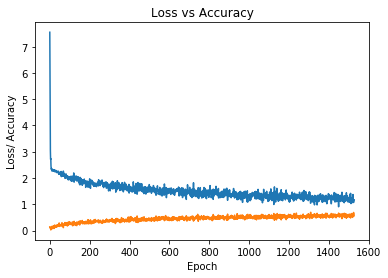

validation for epoch 3
-  epoch 3: validation accuracy = 0.610
train for epoch 4
iteration (1550): loss = 0.945, accuracy = 0.648
iteration (1600): loss = 1.070, accuracy = 0.641
iteration (1650): loss = 1.264, accuracy = 0.500
iteration (1700): loss = 1.083, accuracy = 0.602
iteration (1750): loss = 1.248, accuracy = 0.578
iteration (1800): loss = 1.098, accuracy = 0.617
iteration (1850): loss = 1.080, accuracy = 0.656
iteration (1900): loss = 1.057, accuracy = 0.664


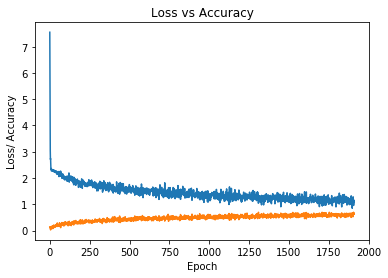

validation for epoch 4
-  epoch 4: validation accuracy = 0.628
train for epoch 5
iteration (1950): loss = 1.207, accuracy = 0.609
iteration (2000): loss = 1.132, accuracy = 0.570
iteration (2050): loss = 1.243, accuracy = 0.570
iteration (2100): loss = 1.111, accuracy = 0.594
iteration (2150): loss = 1.291, accuracy = 0.539
iteration (2200): loss = 1.189, accuracy = 0.586
iteration (2250): loss = 0.974, accuracy = 0.641


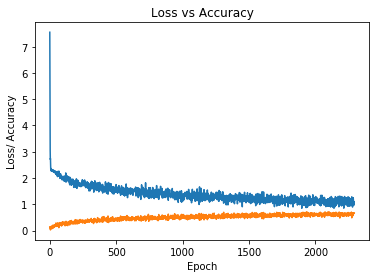

validation for epoch 5
-  epoch 5: validation accuracy = 0.643
train for epoch 6
iteration (2300): loss = 0.992, accuracy = 0.609
iteration (2350): loss = 1.011, accuracy = 0.633
iteration (2400): loss = 1.096, accuracy = 0.578
iteration (2450): loss = 1.195, accuracy = 0.547
iteration (2500): loss = 1.148, accuracy = 0.625
iteration (2550): loss = 1.034, accuracy = 0.633
iteration (2600): loss = 1.047, accuracy = 0.609
iteration (2650): loss = 1.046, accuracy = 0.648


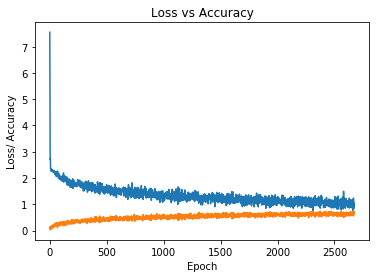

validation for epoch 6
-  epoch 6: validation accuracy = 0.654
train for epoch 7
iteration (2700): loss = 1.255, accuracy = 0.578
iteration (2750): loss = 1.031, accuracy = 0.633
iteration (2800): loss = 0.981, accuracy = 0.641
iteration (2850): loss = 1.041, accuracy = 0.633
iteration (2900): loss = 0.828, accuracy = 0.672
iteration (2950): loss = 0.922, accuracy = 0.688
iteration (3000): loss = 0.812, accuracy = 0.711
iteration (3050): loss = 1.026, accuracy = 0.602


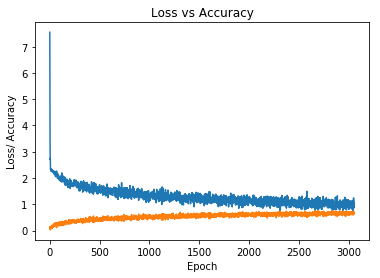

validation for epoch 7
-  epoch 7: validation accuracy = 0.665
train for epoch 8
iteration (3100): loss = 0.970, accuracy = 0.641
iteration (3150): loss = 1.078, accuracy = 0.664
iteration (3200): loss = 0.964, accuracy = 0.672
iteration (3250): loss = 0.906, accuracy = 0.695
iteration (3300): loss = 0.776, accuracy = 0.734
iteration (3350): loss = 1.003, accuracy = 0.664
iteration (3400): loss = 0.876, accuracy = 0.656


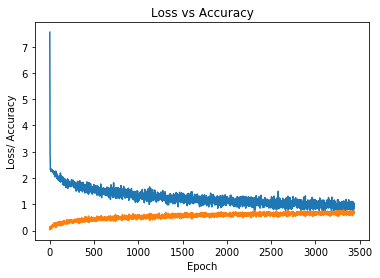

validation for epoch 8
-  epoch 8: validation accuracy = 0.682
train for epoch 9
iteration (3450): loss = 0.794, accuracy = 0.703
iteration (3500): loss = 1.004, accuracy = 0.625
iteration (3550): loss = 0.913, accuracy = 0.648
iteration (3600): loss = 0.946, accuracy = 0.688
iteration (3650): loss = 1.190, accuracy = 0.609
iteration (3700): loss = 0.956, accuracy = 0.633
iteration (3750): loss = 0.738, accuracy = 0.727
iteration (3800): loss = 0.904, accuracy = 0.711


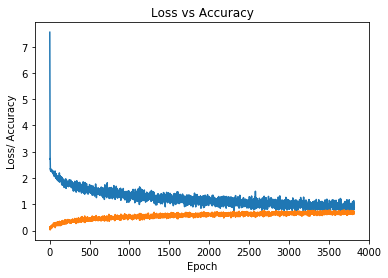

validation for epoch 9
-  epoch 9: validation accuracy = 0.706
train for epoch 10
iteration (3850): loss = 0.824, accuracy = 0.727
iteration (3900): loss = 0.893, accuracy = 0.695
iteration (3950): loss = 0.872, accuracy = 0.680
iteration (4000): loss = 0.801, accuracy = 0.758
iteration (4050): loss = 0.869, accuracy = 0.688
iteration (4100): loss = 0.893, accuracy = 0.711
iteration (4150): loss = 0.800, accuracy = 0.703
iteration (4200): loss = 0.961, accuracy = 0.727


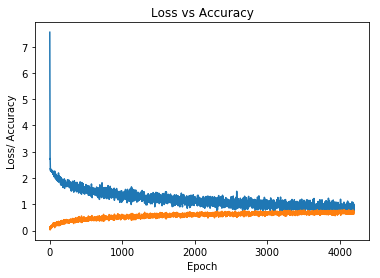

validation for epoch 10
-  epoch 10: validation accuracy = 0.690
train for epoch 11
iteration (4250): loss = 0.715, accuracy = 0.664
iteration (4300): loss = 0.952, accuracy = 0.703
iteration (4350): loss = 0.909, accuracy = 0.672
iteration (4400): loss = 0.845, accuracy = 0.695
iteration (4450): loss = 0.850, accuracy = 0.734
iteration (4500): loss = 0.938, accuracy = 0.648
iteration (4550): loss = 0.929, accuracy = 0.711


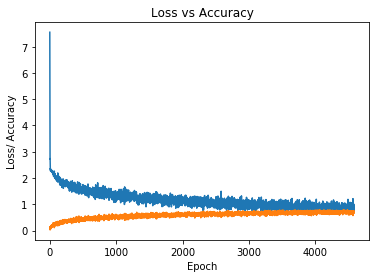

validation for epoch 11
-  epoch 11: validation accuracy = 0.699
train for epoch 12
iteration (4600): loss = 0.717, accuracy = 0.758
iteration (4650): loss = 0.912, accuracy = 0.680
iteration (4700): loss = 0.876, accuracy = 0.695
iteration (4750): loss = 0.842, accuracy = 0.703
iteration (4800): loss = 0.830, accuracy = 0.727
iteration (4850): loss = 0.685, accuracy = 0.766
iteration (4900): loss = 0.936, accuracy = 0.688
iteration (4950): loss = 0.709, accuracy = 0.727


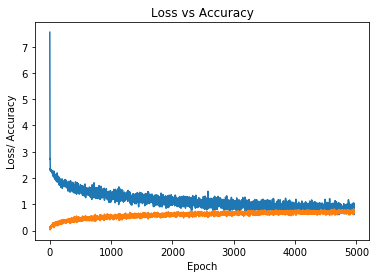

validation for epoch 12
-  epoch 12: validation accuracy = 0.711
train for epoch 13
iteration (5000): loss = 0.629, accuracy = 0.758
iteration (5050): loss = 0.825, accuracy = 0.727
iteration (5100): loss = 0.764, accuracy = 0.758
iteration (5150): loss = 0.767, accuracy = 0.695
iteration (5200): loss = 0.698, accuracy = 0.773
iteration (5250): loss = 0.748, accuracy = 0.719
iteration (5300): loss = 0.791, accuracy = 0.711


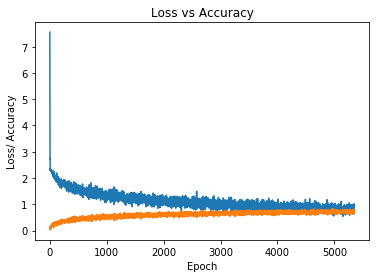

validation for epoch 13
-  epoch 13: validation accuracy = 0.710
train for epoch 14
iteration (5350): loss = 0.830, accuracy = 0.703
iteration (5400): loss = 0.771, accuracy = 0.750
iteration (5450): loss = 0.764, accuracy = 0.758
iteration (5500): loss = 0.725, accuracy = 0.766
iteration (5550): loss = 0.810, accuracy = 0.750
iteration (5600): loss = 0.735, accuracy = 0.727
iteration (5650): loss = 0.731, accuracy = 0.734
iteration (5700): loss = 0.905, accuracy = 0.680


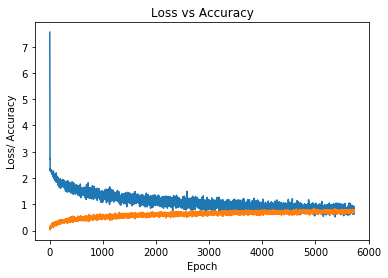

validation for epoch 14
-  epoch 14: validation accuracy = 0.725
train for epoch 15
iteration (5750): loss = 0.486, accuracy = 0.844
iteration (5800): loss = 1.008, accuracy = 0.633
iteration (5850): loss = 0.593, accuracy = 0.805
iteration (5900): loss = 0.807, accuracy = 0.695
iteration (5950): loss = 0.625, accuracy = 0.742
iteration (6000): loss = 0.717, accuracy = 0.758
iteration (6050): loss = 0.791, accuracy = 0.734
iteration (6100): loss = 0.756, accuracy = 0.734


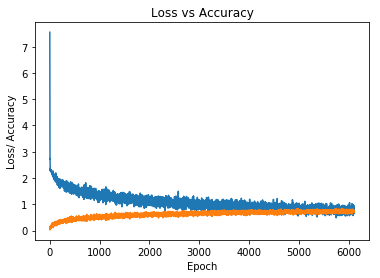

validation for epoch 15
-  epoch 15: validation accuracy = 0.724
train for epoch 16
iteration (6150): loss = 0.912, accuracy = 0.688
iteration (6200): loss = 0.936, accuracy = 0.711
iteration (6250): loss = 0.939, accuracy = 0.688
iteration (6300): loss = 0.693, accuracy = 0.758
iteration (6350): loss = 0.701, accuracy = 0.742
iteration (6400): loss = 0.959, accuracy = 0.672
iteration (6450): loss = 0.829, accuracy = 0.664


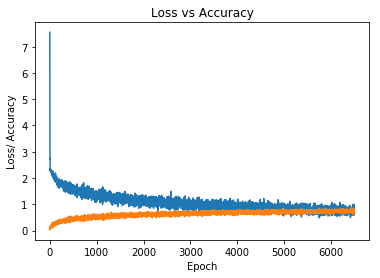

validation for epoch 16
-  epoch 16: validation accuracy = 0.689
train for epoch 17
iteration (6500): loss = 0.784, accuracy = 0.664
iteration (6550): loss = 0.755, accuracy = 0.727
iteration (6600): loss = 0.711, accuracy = 0.758
iteration (6650): loss = 0.697, accuracy = 0.758
iteration (6700): loss = 0.653, accuracy = 0.797
iteration (6750): loss = 0.747, accuracy = 0.742
iteration (6800): loss = 0.726, accuracy = 0.789
iteration (6850): loss = 0.697, accuracy = 0.742


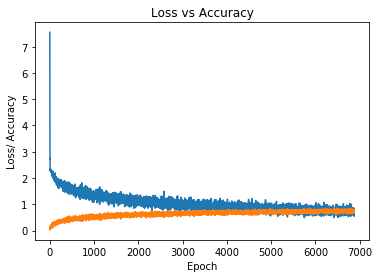

validation for epoch 17
-  epoch 17: validation accuracy = 0.709
train for epoch 18
iteration (6900): loss = 0.679, accuracy = 0.734
iteration (6950): loss = 0.638, accuracy = 0.773
iteration (7000): loss = 0.836, accuracy = 0.719
iteration (7050): loss = 0.638, accuracy = 0.750
iteration (7100): loss = 0.613, accuracy = 0.781
iteration (7150): loss = 0.823, accuracy = 0.695
iteration (7200): loss = 0.788, accuracy = 0.703
iteration (7250): loss = 0.682, accuracy = 0.773


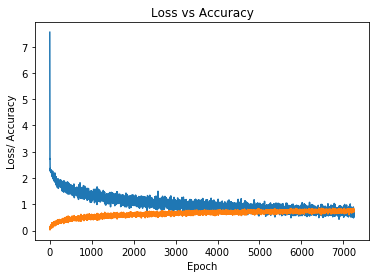

validation for epoch 18
-  epoch 18: validation accuracy = 0.721
train for epoch 19
iteration (7300): loss = 0.876, accuracy = 0.695
iteration (7350): loss = 0.748, accuracy = 0.719
iteration (7400): loss = 0.805, accuracy = 0.719
iteration (7450): loss = 0.579, accuracy = 0.781
iteration (7500): loss = 0.555, accuracy = 0.828
iteration (7550): loss = 0.627, accuracy = 0.742
iteration (7600): loss = 0.729, accuracy = 0.695


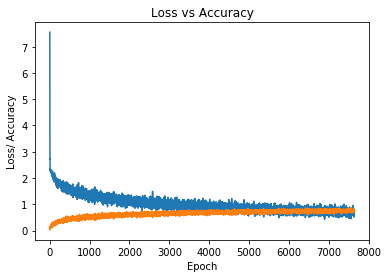

validation for epoch 19
-  epoch 19: validation accuracy = 0.729
train for epoch 20
iteration (7650): loss = 0.657, accuracy = 0.773
iteration (7700): loss = 0.706, accuracy = 0.719
iteration (7750): loss = 0.539, accuracy = 0.820
iteration (7800): loss = 0.616, accuracy = 0.836
iteration (7850): loss = 0.562, accuracy = 0.820
iteration (7900): loss = 0.637, accuracy = 0.766
iteration (7950): loss = 0.756, accuracy = 0.719
iteration (8000): loss = 0.559, accuracy = 0.812


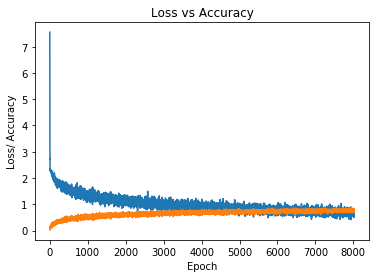

validation for epoch 20
-  epoch 20: validation accuracy = 0.733
train for epoch 21
iteration (8050): loss = 0.635, accuracy = 0.758
iteration (8100): loss = 0.709, accuracy = 0.734
iteration (8150): loss = 0.645, accuracy = 0.781
iteration (8200): loss = 0.633, accuracy = 0.773
iteration (8250): loss = 0.548, accuracy = 0.820
iteration (8300): loss = 0.617, accuracy = 0.781
iteration (8350): loss = 0.643, accuracy = 0.789
iteration (8400): loss = 0.476, accuracy = 0.820


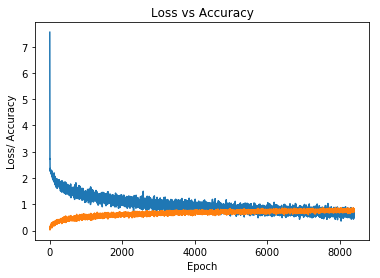

validation for epoch 21
-  epoch 21: validation accuracy = 0.733
train for epoch 22
iteration (8450): loss = 0.576, accuracy = 0.781
iteration (8500): loss = 0.620, accuracy = 0.742
iteration (8550): loss = 0.683, accuracy = 0.789
iteration (8600): loss = 0.631, accuracy = 0.812
iteration (8650): loss = 0.521, accuracy = 0.828
iteration (8700): loss = 0.832, accuracy = 0.672
iteration (8750): loss = 0.703, accuracy = 0.750


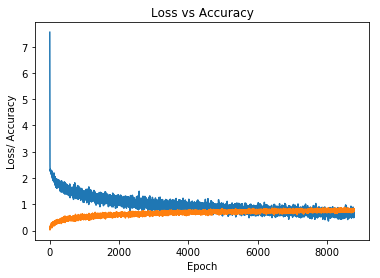

validation for epoch 22
-  epoch 22: validation accuracy = 0.723
train for epoch 23
iteration (8800): loss = 0.517, accuracy = 0.789
iteration (8850): loss = 0.607, accuracy = 0.820
iteration (8900): loss = 0.690, accuracy = 0.750
iteration (8950): loss = 0.520, accuracy = 0.820
iteration (9000): loss = 0.518, accuracy = 0.828
iteration (9050): loss = 0.665, accuracy = 0.773
iteration (9100): loss = 0.548, accuracy = 0.812
iteration (9150): loss = 0.524, accuracy = 0.805


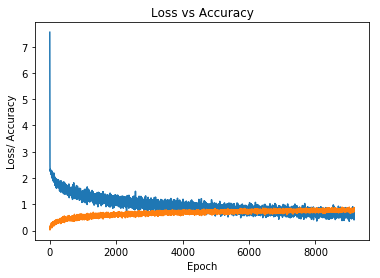

validation for epoch 23
-  epoch 23: validation accuracy = 0.713
train for epoch 24
iteration (9200): loss = 0.603, accuracy = 0.773
iteration (9250): loss = 0.649, accuracy = 0.812
iteration (9300): loss = 0.478, accuracy = 0.805
iteration (9350): loss = 0.599, accuracy = 0.758
iteration (9400): loss = 0.567, accuracy = 0.812
iteration (9450): loss = 0.596, accuracy = 0.789
iteration (9500): loss = 0.775, accuracy = 0.727


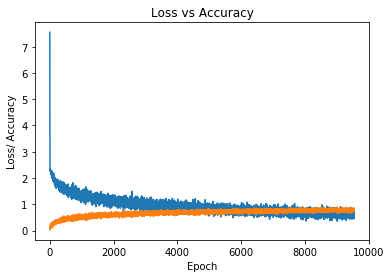

validation for epoch 24
-  epoch 24: validation accuracy = 0.743
train for epoch 25
iteration (9550): loss = 0.542, accuracy = 0.820
iteration (9600): loss = 0.593, accuracy = 0.812
iteration (9650): loss = 0.433, accuracy = 0.844
iteration (9700): loss = 0.459, accuracy = 0.859
iteration (9750): loss = 0.696, accuracy = 0.750
iteration (9800): loss = 0.613, accuracy = 0.805
iteration (9850): loss = 0.654, accuracy = 0.812
iteration (9900): loss = 0.820, accuracy = 0.766


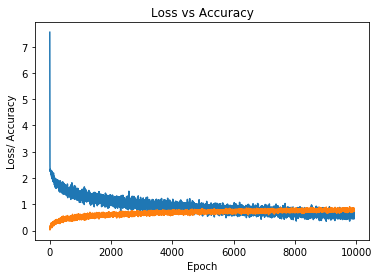

validation for epoch 25
-  epoch 25: validation accuracy = 0.733
train for epoch 26
iteration (9950): loss = 0.555, accuracy = 0.773
iteration (10000): loss = 0.569, accuracy = 0.805
iteration (10050): loss = 0.577, accuracy = 0.789
iteration (10100): loss = 0.510, accuracy = 0.828
iteration (10150): loss = 0.474, accuracy = 0.820
iteration (10200): loss = 0.705, accuracy = 0.742
iteration (10250): loss = 0.526, accuracy = 0.805
iteration (10300): loss = 0.558, accuracy = 0.773


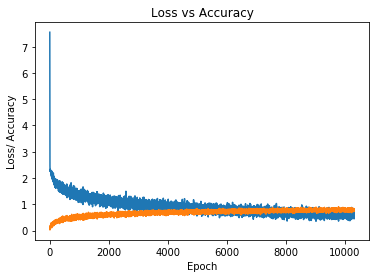

validation for epoch 26
-  epoch 26: validation accuracy = 0.735
train for epoch 27
iteration (10350): loss = 0.514, accuracy = 0.805
iteration (10400): loss = 0.568, accuracy = 0.734
iteration (10450): loss = 0.517, accuracy = 0.797
iteration (10500): loss = 0.492, accuracy = 0.852
iteration (10550): loss = 0.455, accuracy = 0.820
iteration (10600): loss = 0.604, accuracy = 0.773
iteration (10650): loss = 0.559, accuracy = 0.797


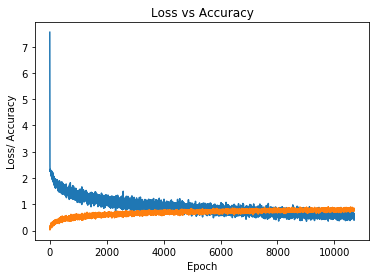

validation for epoch 27
-  epoch 27: validation accuracy = 0.711
train for epoch 28
iteration (10700): loss = 0.477, accuracy = 0.805
iteration (10750): loss = 0.502, accuracy = 0.797
iteration (10800): loss = 0.533, accuracy = 0.812
iteration (10850): loss = 0.659, accuracy = 0.727
iteration (10900): loss = 0.467, accuracy = 0.812
iteration (10950): loss = 0.607, accuracy = 0.797
iteration (11000): loss = 0.573, accuracy = 0.805
iteration (11050): loss = 0.600, accuracy = 0.773


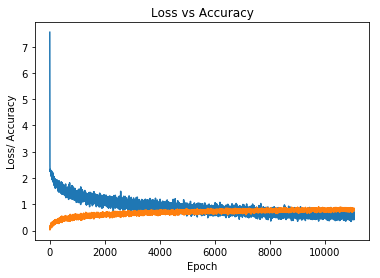

validation for epoch 28
-  epoch 28: validation accuracy = 0.728
train for epoch 29
iteration (11100): loss = 0.417, accuracy = 0.836
iteration (11150): loss = 0.560, accuracy = 0.836
iteration (11200): loss = 0.600, accuracy = 0.789
iteration (11250): loss = 0.576, accuracy = 0.773
iteration (11300): loss = 0.481, accuracy = 0.805
iteration (11350): loss = 0.523, accuracy = 0.836
iteration (11400): loss = 0.566, accuracy = 0.797
iteration (11450): loss = 0.494, accuracy = 0.828


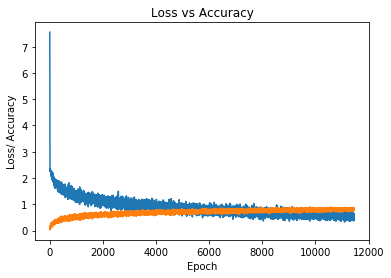

validation for epoch 29
-  epoch 29: validation accuracy = 0.731
train for epoch 30
iteration (11500): loss = 0.510, accuracy = 0.805
iteration (11550): loss = 0.396, accuracy = 0.852
iteration (11600): loss = 0.624, accuracy = 0.789
iteration (11650): loss = 0.599, accuracy = 0.773
iteration (11700): loss = 0.702, accuracy = 0.727
iteration (11750): loss = 0.479, accuracy = 0.820
iteration (11800): loss = 0.423, accuracy = 0.844


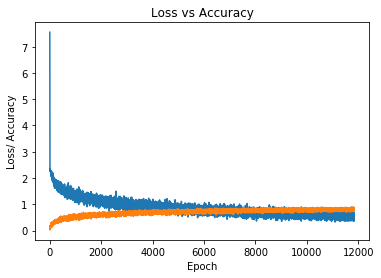

validation for epoch 30
-  epoch 30: validation accuracy = 0.723
train for epoch 31
iteration (11850): loss = 0.450, accuracy = 0.812
iteration (11900): loss = 0.316, accuracy = 0.898
iteration (11950): loss = 0.565, accuracy = 0.781
iteration (12000): loss = 0.467, accuracy = 0.836
iteration (12050): loss = 0.505, accuracy = 0.797
iteration (12100): loss = 0.535, accuracy = 0.797
iteration (12150): loss = 0.512, accuracy = 0.828
iteration (12200): loss = 0.452, accuracy = 0.836


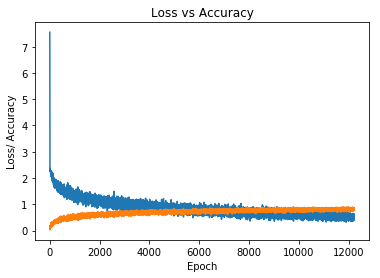

validation for epoch 31
-  epoch 31: validation accuracy = 0.758
train for epoch 32
iteration (12250): loss = 0.485, accuracy = 0.836
iteration (12300): loss = 0.600, accuracy = 0.773
iteration (12350): loss = 0.458, accuracy = 0.828
iteration (12400): loss = 0.463, accuracy = 0.828
iteration (12450): loss = 0.382, accuracy = 0.836
iteration (12500): loss = 0.547, accuracy = 0.820
iteration (12550): loss = 0.441, accuracy = 0.852
iteration (12600): loss = 0.525, accuracy = 0.828


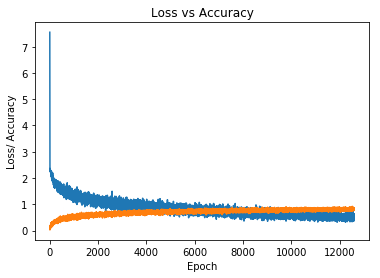

validation for epoch 32
-  epoch 32: validation accuracy = 0.725
train for epoch 33
iteration (12650): loss = 0.494, accuracy = 0.789
iteration (12700): loss = 0.668, accuracy = 0.727
iteration (12750): loss = 0.515, accuracy = 0.797
iteration (12800): loss = 0.506, accuracy = 0.789
iteration (12850): loss = 0.311, accuracy = 0.859
iteration (12900): loss = 0.486, accuracy = 0.828
iteration (12950): loss = 0.429, accuracy = 0.836


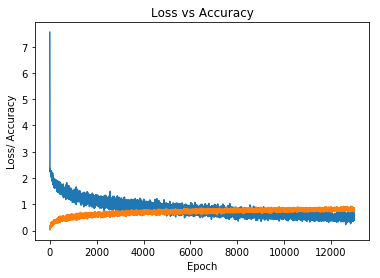

validation for epoch 33
-  epoch 33: validation accuracy = 0.746
train for epoch 34
iteration (13000): loss = 0.344, accuracy = 0.906
iteration (13050): loss = 0.455, accuracy = 0.820
iteration (13100): loss = 0.458, accuracy = 0.820
iteration (13150): loss = 0.405, accuracy = 0.852
iteration (13200): loss = 0.530, accuracy = 0.781
iteration (13250): loss = 0.567, accuracy = 0.781
iteration (13300): loss = 0.468, accuracy = 0.797
iteration (13350): loss = 0.483, accuracy = 0.805


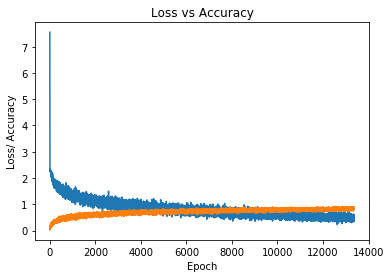

validation for epoch 34
-  epoch 34: validation accuracy = 0.740
train for epoch 35
iteration (13400): loss = 0.469, accuracy = 0.820
iteration (13450): loss = 0.539, accuracy = 0.828
iteration (13500): loss = 0.462, accuracy = 0.836
iteration (13550): loss = 0.496, accuracy = 0.828
iteration (13600): loss = 0.442, accuracy = 0.812
iteration (13650): loss = 0.669, accuracy = 0.805
iteration (13700): loss = 0.574, accuracy = 0.805
iteration (13750): loss = 0.507, accuracy = 0.828


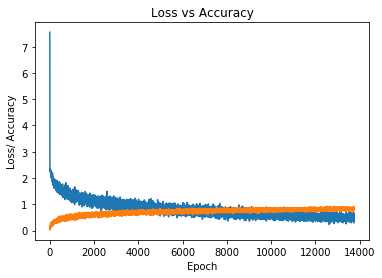

validation for epoch 35
-  epoch 35: validation accuracy = 0.750
train for epoch 36
iteration (13800): loss = 0.394, accuracy = 0.852
iteration (13850): loss = 0.453, accuracy = 0.867
iteration (13900): loss = 0.485, accuracy = 0.844
iteration (13950): loss = 0.604, accuracy = 0.773
iteration (14000): loss = 0.405, accuracy = 0.867
iteration (14050): loss = 0.433, accuracy = 0.844
iteration (14100): loss = 0.478, accuracy = 0.836


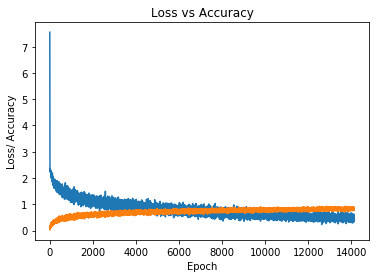

validation for epoch 36
-  epoch 36: validation accuracy = 0.734
train for epoch 37
iteration (14150): loss = 0.355, accuracy = 0.906
iteration (14200): loss = 0.463, accuracy = 0.836
iteration (14250): loss = 0.485, accuracy = 0.812
iteration (14300): loss = 0.411, accuracy = 0.836
iteration (14350): loss = 0.353, accuracy = 0.859
iteration (14400): loss = 0.330, accuracy = 0.867
iteration (14450): loss = 0.367, accuracy = 0.859
iteration (14500): loss = 0.412, accuracy = 0.836


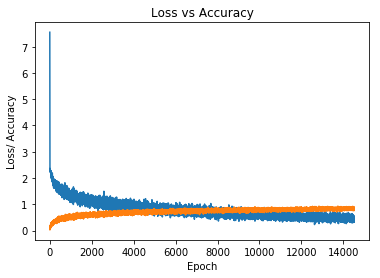

validation for epoch 37
-  epoch 37: validation accuracy = 0.748
train for epoch 38
iteration (14550): loss = 0.322, accuracy = 0.883
iteration (14600): loss = 0.527, accuracy = 0.820
iteration (14650): loss = 0.387, accuracy = 0.867
iteration (14700): loss = 0.374, accuracy = 0.898
iteration (14750): loss = 0.272, accuracy = 0.898
iteration (14800): loss = 0.404, accuracy = 0.852
iteration (14850): loss = 0.412, accuracy = 0.898


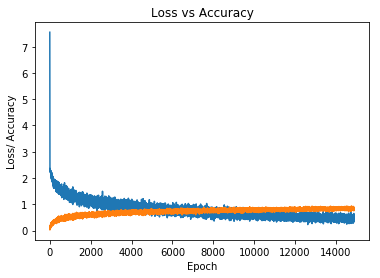

validation for epoch 38
-  epoch 38: validation accuracy = 0.734
train for epoch 39
iteration (14900): loss = 0.496, accuracy = 0.820
iteration (14950): loss = 0.312, accuracy = 0.883
iteration (15000): loss = 0.394, accuracy = 0.867
iteration (15050): loss = 0.429, accuracy = 0.828
iteration (15100): loss = 0.526, accuracy = 0.805
iteration (15150): loss = 0.338, accuracy = 0.875
iteration (15200): loss = 0.436, accuracy = 0.828
iteration (15250): loss = 0.425, accuracy = 0.852


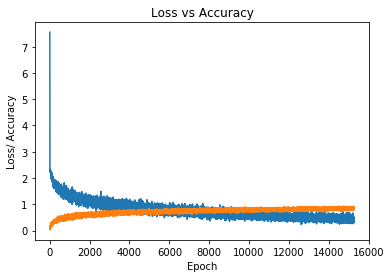

validation for epoch 39
-  epoch 39: validation accuracy = 0.748
train for epoch 40
iteration (15300): loss = 0.243, accuracy = 0.914
iteration (15350): loss = 0.686, accuracy = 0.727
iteration (15400): loss = 0.298, accuracy = 0.859
iteration (15450): loss = 0.460, accuracy = 0.828
iteration (15500): loss = 0.334, accuracy = 0.867
iteration (15550): loss = 0.345, accuracy = 0.867
iteration (15600): loss = 0.407, accuracy = 0.828
iteration (15650): loss = 0.432, accuracy = 0.820


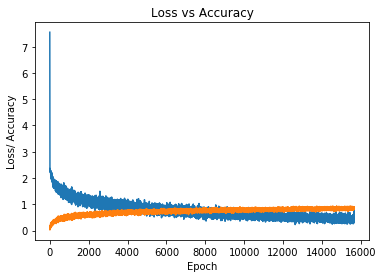

validation for epoch 40
-  epoch 40: validation accuracy = 0.742
train for epoch 41
iteration (15700): loss = 0.458, accuracy = 0.859
iteration (15750): loss = 0.458, accuracy = 0.812
iteration (15800): loss = 0.395, accuracy = 0.852
iteration (15850): loss = 0.569, accuracy = 0.805
iteration (15900): loss = 0.413, accuracy = 0.867
iteration (15950): loss = 0.479, accuracy = 0.859
iteration (16000): loss = 0.542, accuracy = 0.836


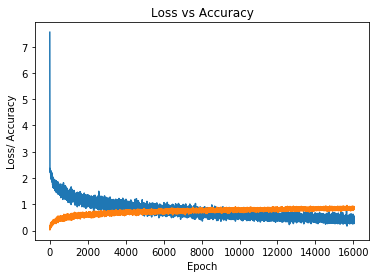

validation for epoch 41
-  epoch 41: validation accuracy = 0.739
train for epoch 42
iteration (16050): loss = 0.451, accuracy = 0.836
iteration (16100): loss = 0.304, accuracy = 0.875
iteration (16150): loss = 0.448, accuracy = 0.828
iteration (16200): loss = 0.360, accuracy = 0.883
iteration (16250): loss = 0.424, accuracy = 0.844
iteration (16300): loss = 0.522, accuracy = 0.859
iteration (16350): loss = 0.453, accuracy = 0.859
iteration (16400): loss = 0.326, accuracy = 0.891


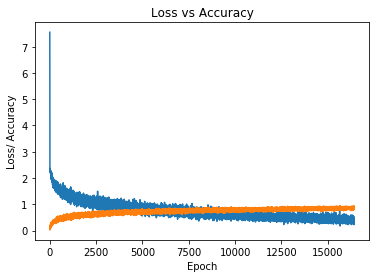

validation for epoch 42
-  epoch 42: validation accuracy = 0.737
train for epoch 43
iteration (16450): loss = 0.347, accuracy = 0.852
iteration (16500): loss = 0.303, accuracy = 0.883
iteration (16550): loss = 0.459, accuracy = 0.805
iteration (16600): loss = 0.436, accuracy = 0.852
iteration (16650): loss = 0.384, accuracy = 0.828
iteration (16700): loss = 0.483, accuracy = 0.852
iteration (16750): loss = 0.618, accuracy = 0.797
iteration (16800): loss = 0.404, accuracy = 0.883


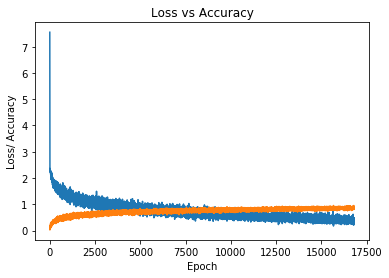

validation for epoch 43
-  epoch 43: validation accuracy = 0.750
train for epoch 44
iteration (16850): loss = 0.433, accuracy = 0.859
iteration (16900): loss = 0.468, accuracy = 0.836
iteration (16950): loss = 0.448, accuracy = 0.820
iteration (17000): loss = 0.324, accuracy = 0.891
iteration (17050): loss = 0.418, accuracy = 0.844
iteration (17100): loss = 0.298, accuracy = 0.898
iteration (17150): loss = 0.289, accuracy = 0.883


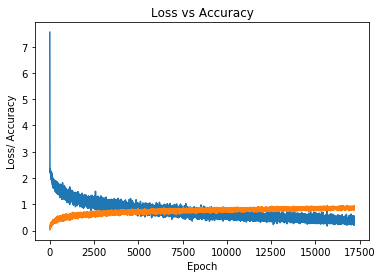

validation for epoch 44
-  epoch 44: validation accuracy = 0.734
train for epoch 45
iteration (17200): loss = 0.345, accuracy = 0.875
iteration (17250): loss = 0.333, accuracy = 0.867
iteration (17300): loss = 0.361, accuracy = 0.828
iteration (17350): loss = 0.348, accuracy = 0.898
iteration (17400): loss = 0.386, accuracy = 0.859
iteration (17450): loss = 0.321, accuracy = 0.883
iteration (17500): loss = 0.468, accuracy = 0.812
iteration (17550): loss = 0.324, accuracy = 0.898


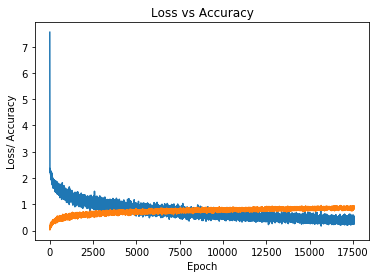

validation for epoch 45
-  epoch 45: validation accuracy = 0.747
train for epoch 46
iteration (17600): loss = 0.314, accuracy = 0.906
iteration (17650): loss = 0.404, accuracy = 0.844
iteration (17700): loss = 0.354, accuracy = 0.852
iteration (17750): loss = 0.370, accuracy = 0.867
iteration (17800): loss = 0.289, accuracy = 0.867
iteration (17850): loss = 0.359, accuracy = 0.859
iteration (17900): loss = 0.390, accuracy = 0.852
iteration (17950): loss = 0.450, accuracy = 0.836


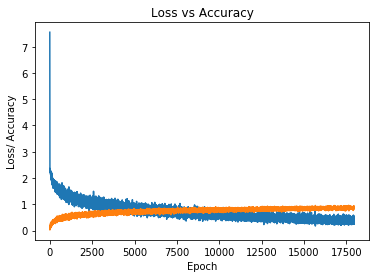

validation for epoch 46
-  epoch 46: validation accuracy = 0.757
train for epoch 47
iteration (18000): loss = 0.255, accuracy = 0.914
iteration (18050): loss = 0.403, accuracy = 0.867
iteration (18100): loss = 0.265, accuracy = 0.891
iteration (18150): loss = 0.293, accuracy = 0.883
iteration (18200): loss = 0.430, accuracy = 0.836
iteration (18250): loss = 0.507, accuracy = 0.812
iteration (18300): loss = 0.266, accuracy = 0.906


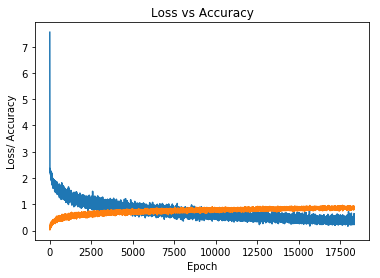

validation for epoch 47
-  epoch 47: validation accuracy = 0.746
train for epoch 48
iteration (18350): loss = 0.235, accuracy = 0.914
iteration (18400): loss = 0.329, accuracy = 0.867
iteration (18450): loss = 0.432, accuracy = 0.836
iteration (18500): loss = 0.239, accuracy = 0.891
iteration (18550): loss = 0.249, accuracy = 0.891
iteration (18600): loss = 0.375, accuracy = 0.859
iteration (18650): loss = 0.303, accuracy = 0.875
iteration (18700): loss = 0.375, accuracy = 0.867


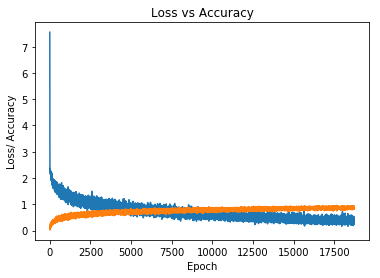

validation for epoch 48
-  epoch 48: validation accuracy = 0.759
train for epoch 49
iteration (18750): loss = 0.396, accuracy = 0.875
iteration (18800): loss = 0.240, accuracy = 0.922
iteration (18850): loss = 0.260, accuracy = 0.898
iteration (18900): loss = 0.329, accuracy = 0.867
iteration (18950): loss = 0.390, accuracy = 0.875
iteration (19000): loss = 0.372, accuracy = 0.852
iteration (19050): loss = 0.399, accuracy = 0.828


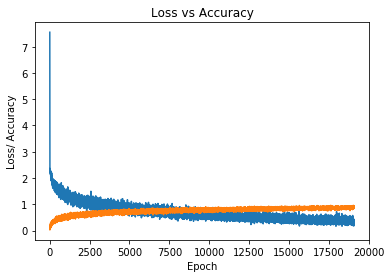

validation for epoch 49
-  epoch 49: validation accuracy = 0.742
***** test accuracy: 0.731
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [15]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
mean_image = np.mean(X_train, axis=0)
X_train_ = X_train - mean_image
X_val_ = X_val - mean_image
X_test_ = X_test - mean_image
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [16]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 32)
flat layer: (?, 512)
fc3 layer: (?, 384)
fc4 layer: (?, 192)
fc4 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
